### Data Visualization - Ideal vs Encountered

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py


#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance
import geopandas as gpd
import utm
import datetime as dt

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from IPython.display import HTML


### Load Data

In [2]:
set_number = 5

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
windbag = 'wind0'+str(set_number)+'Run03.hdf'
westeast_load = 'ewdata0'+str(set_number)+'Run03.hdf'
northsouth_load= 'nsdata0'+str(set_number)+'Run03.hdf'
odor_load = 'Interpolated_'+str(set_number)+'.h5'


In [3]:
#puffsize = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/puff_size.hdf')

In [4]:
#windbag
wind=pd.read_hdf(dir+windbag)
we=pd.read_hdf(dir+westeast_load)
ns=pd.read_hdf(dir+northsouth_load)

In [5]:
#odorbag
odor= pd.read_hdf(dir+odor_load)
time= odor.master_time-odor.master_time[0]
odor.insert(1,'sync_time',time) 

### Creating Dataframe for Puff Size

In [40]:
def puff_radius(row,col):
    if (row > col):
        return (row - col)
    else:
        return (0)

In [21]:
# # creating puff dataframe
# # going to copy to a new frame to keep this container separate as the for loop takes significant time to execute

# puff = pd.DataFrame(index=range(10008),columns=range(10008))
# puffsize=pd.DataFrame()

# for i in range(0, len(puff.columns)):
#     puff[i]=puff.index

# puff.columns = ['particle' + str(col) for col in puff.columns] #renaming for looping ease
# puffsize[0] = puff.iloc[:,0] #copying the first columns of data

# #shifting every column by the column-th number
# for i in range(1, len(puff.columns)):
#     puffsize[i]=puff['particle' + str(i)].shift(periods=i)

# puffsize=puffsize.fillna(0) #replacing NaN with zeroes
# puffsize.columns = ['particle' + str(col) for col in puffsize.columns] #renaming columns names optional
# puffsize= puffsize.astype(int)
# puffsize.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/puff_size.hdf', key='puffsize', mode='w')

### Converting lat lon information to meters

In [6]:
from shapely.geometry import Point
odor['geometry'] = odor.apply(lambda row: Point(row.lon, row.lat), axis=1)

geodf = gpd.GeoDataFrame(odor)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_def")

geodf["x"] = geodf.geometry.apply(lambda row:row.x)
geodf["y"] = geodf.geometry.apply(lambda row:row.y)

In [7]:
#source location to meters
source = (40.79376709443614, -119.15757512132207)
u =  utm.from_latlon(40.79376709443614, -119.15757512132207)

In [8]:
#adding sync_time from zero, optional

newtime= wind.sync_time-wind.sync_time.iloc[0]
wind.insert(1,'ntime',newtime) 

newtime=newtime.reset_index()
# newtime = newtime.drop(columns=['index'])

we.insert(0,'sync_time',newtime.sync_time)
ns.insert(0,'sync_time',newtime.sync_time)

In [9]:
xfromsrc= geodf.x-u[0]
geodf.insert(10,'xsrc',xfromsrc) 

yfromsrc = geodf.y-u[1]
geodf.insert(11,'ysrc', yfromsrc)

### Selecting a smaller slot of data

In [10]:
query = 'sync_time >= 100  and sync_time <=120'
dfo = odor.query(query)
dfwe = we.query(query)
dfns = ns.query(query)
dfwe = dfwe.reset_index()
dfns = dfns.reset_index()
geodfsub = geodf.query(query)
geodfsub = geodfsub.reset_index()

In [11]:
len(geodfsub)

4004

In [12]:
# # # drop additional time stamps if necessary
# dfns = dfns.drop(columns=[ 'index1', 'sync_time'])
# dfwe = dfwe.drop(columns=['index', 'sync_time'])
# geodfsub = geodfsub.drop(columns = ['index', 'size'])

In [12]:
#ns = ns.reset_index()
# we = we.drop(columns=['sync_time'])
dfns = dfns.drop(columns=['index1'])
dfwe = dfwe.drop(columns=['index'])
geodfsub = geodfsub.drop(columns = ['index'])

### Interpolate

In [14]:
# df_odor_loc=pd.DataFrame({'odor_time': geodf.master_time,'xsrc': geodf.xsrc, 'ysrc':geodf.ysrc,})
# df_wind_loc=pd.DataFrame({'wind_time': wind.time_epoch,'U': wind.U,'V': wind.V,})

# df_new = pd.concat([df_odor_loc,df_wind_loc], sort=True)
# combined_time = np.hstack([df_odor_loc.odor_time, df_wind_loc.wind_time])

# df_new['time'] = combined_time
# df_new=df_new.sort_values(by=['time'])

In [15]:
# dt_odor = np.median(np.diff(df_new.odor_time.dropna().values))
# print('dt Odor: ', dt_odor)
# dt_wind = np.median(np.diff(df_new.wind_time.dropna().values))
# print('dt Wind: ', dt_wind)

# first_time = np.max([df_new.odor_time.min(), df_new.wind_time.min()])
# last_time = np.min([df_new.odor_time.max(), df_new.wind_time.max()])
# master_time = np.arange(first_time, last_time, dt_odor)

In [17]:
# create interpolation function and inteprolate sensor 1
# df_odor_1= df_new[['odor_time', 'xsrc']].dropna()
# func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.xsrc)
# interp_odor_x = func_interp_sensor_1(master_time)

# df_odor_2= df_new[['odor_time', 'ysrc']].dropna()
# func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_2.odor_time, df_odor_2.ysrc)
# interp_odor_y = func_interp_sensor_1(master_time)

# df_wind_1= df_new[['wind_time', 'U']].dropna()
# func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.U)
# interp_wind_U = func_interp_sensor_1(master_time)

# df_wind_2= df_new[['wind_time', 'V']].dropna()
# func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.V)
# interp_wind_V = func_interp_sensor_1(master_time)

# windn = pd.DataFrame({'master_time': master_time,
#                            'xsrc': interp_odor_x,
#                            'ysrc': interp_odor_y,
#                            'U': interp_wind_U,
#                            'V': interp_wind_V,})

In [19]:
# windn.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_Interpolated.hdf', key='df2', mode='w')

In [13]:
windn=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_Interpolated.hdf')
windn_sync_time=windn.master_time-windn.master_time[0]
windn.insert(1,'sync_time',windn_sync_time)

In [14]:
#select a sub data
windnsub=windn.query(query)

In [15]:
posu=[]
posv=[]
for i in range(len(windnsub.master_time)):
    posu.append(integrate.cumtrapz(windnsub.U[i:],windnsub.master_time[i:], axis=0, initial = 0.0)) 
    posv.append(integrate.cumtrapz(windnsub.V[i:],windnsub.master_time[i:], axis=0, initial = 0.0))

In [16]:
#creating dataframes for each westeast particle and northsouth
westeast=pd.DataFrame(posu,columns=['particle{}'.format(x+1) for x in range(len(posu))]) #particle U
northsouth=pd.DataFrame(posv,columns=['particle{}'.format(x+1) for x in range(len(posv))]) #particle in V

In [17]:
dfi = pd.DataFrame()
dfi['index']=westeast.index
westeast=westeast.T
westeast.set_index(dfi.index, inplace=True)
westeast.columns = ['particle' + str(col) for col in westeast.columns]
delta=pd.DataFrame()
delta[0] = westeast.iloc[:,0]
for i in range(1,len(westeast.columns)):
    delta[i]=westeast['particle' + str(i)].shift(periods=i)

delta.columns = ['particle' + str(col) for col in delta.columns]
delta=delta.fillna(0)
delta.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_Delta.hdf', key='df2', mode='w')

In [18]:
#converting rows to columns for position northsouth
dfi['index1']=northsouth.index
northsouth=northsouth.T
northsouth.set_index(dfi.index1, inplace=True)
northsouth.columns = ['particle' + str(col) for col in northsouth.columns]
gamma=pd.DataFrame()
gamma[0] = northsouth.iloc[:,0]
for i in range(1,len(westeast.columns)):
    gamma[i]=northsouth['particle' + str(i)].shift(periods=i)
    
gamma.columns = ['particle' + str(col) for col in gamma.columns]
gamma=gamma.fillna(0)
gamma.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_Gamma.hdf', key='df2', mode='w')

In [19]:
windnsub = windnsub.reset_index()
windnsub = windnsub.drop(columns=['index'])

In [60]:
def run_euc(point1,point2):
    return np.array([[ np.linalg.norm(i-j) for j in point2] for i in point1])

In [61]:
point1 = np.array([[0,1], [0,2], [0,3], [0,4], [0,5]])
point2 = np.array([[0,1]])

print(run_euc(point1, point2))

[[0.]
 [1.]
 [2.]
 [3.]
 [4.]]


In [53]:
## finding encountered odor withing the calculated odor radius
odor_presence=[]
l = 0
for i in range(0):
    k=0
    windx=delta.loc[i]
    windy=gamma.loc[i]
    wind_pos = np.vstack((windx, windy)).T
    point1 = np.array((geodfsub.xsrc[i],geodfsub.ysrc[i]))
    #     for j in range(l):
#         point2 = np.array((windx[j],windy[j]))
#         distance = np.linalg.norm(point1-point2)

#         if(distance<=puff_radius(i,j)):
#             k+=1            
#         else:
#             k+=0
    
#     if(k>0):
#         odor_presence.append(1)
#     else:
#         odor_presence.append(0)

[[-1.94298462e+01  3.75709150e+01]
 [-1.94254667e+01  3.75619911e+01]
 [-1.94210472e+01  3.75530898e+01]
 ...
 [-7.34385967e-03  1.03670225e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]


In [94]:
odor_expected = []
for i in range(len(odor_presence)):
    if(odor_presence[i]==1):
        odor_expected.append(geodfsub.odor[i])
    else:
        odor_expected.append(0)

In [95]:
geodfsub['odor_expected']=odor_expected

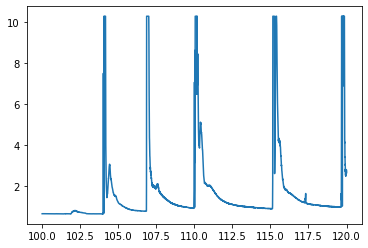

In [96]:
plt.plot(geodfsub.sync_time,geodfsub.odor)

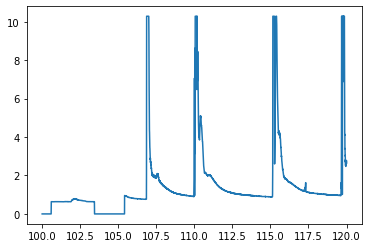

In [97]:
plt.plot(geodfsub.sync_time, geodfsub.odor_expected)

#### Animation method using multiple plots (extremely slow)

In [15]:
dir = '../../../Research/Images/container_odor/'
N = 0
for i in range(len(geodf.xsrc)):
    fig = plt.figure()
    fig.suptitle('Odor Encounters')
    ax = plt.axes (xlim=(-8,15), ylim=(-2,30))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
    if (i<=3000):
        ax.scatter(geodf.xsrc[:i],geodf.ysrc[:i], c=geodf.odor[:i], cmap='magma', s=15)
    else:
        ax.scatter(geodf.xsrc[N:i],geodf.ysrc[N:i], c=geodf.odor[N:i], cmap='magma', s=15)
        N=N+1
        
    fig.savefig(dir + "plot" + str(i) + ".jpg")
    plt.close()

In [166]:
dir = '../../../Research/Images/container_wind/'
for i in range(len(we)):
    fig = plt.figure()
    fig.suptitle('Odor Encounters')
    ax = plt.axes (xlim=(-8,15), ylim=(-2,30))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
    ax.scatter(we.loc[i], ns.loc[i],c ='b', cmap='magma', s=puffsize.loc[i]* 0.1)
    plt.plot(0,0, marker='x', markersize=15)
    fig.savefig(dir + "plot" + str(i) + ".jpg")
    plt.close()

In [7]:
fig = plt.figure()
ax = plt.axes(xlim=(-22,2), ylim=(-15,30))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()
line, = ax.scatter([],[], 'o', c =geodfsub.odor lw=2)

def init():
    line.set_data([],[])
    return line,

def get_data_x(i):
    return we.loc[i]

def get_data_y(i):
    return ns.loc[i]

def update(i):
    x = get_data_x(i)
    y = get_data_y(i)
    line.set_data(x,y)
    return line,

an = animation.FuncAnimation(fig,update,frames = pd.Index.intersection(we.index,ns.index),
                              interval = 5, blit=False)
#an.save('../../../Research/Images/Video/fast_flow.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
# plt.show()

#### 2D scatter plot for entire 300 seconds for ideal vs actual odor counters

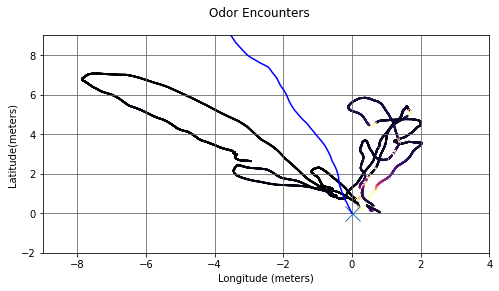

In [57]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor Encounters')
ax = plt.axes (xlim=(-9,4), ylim=(-2,9))
# Plot the data
ax.scatter(geodfsub.xsrc, geodfsub.ysrc, c=geodfsub.odor, cmap='magma', s= 0.8)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, c='b')


#### 2D scatter plot for high odor concentration vs ideal wind particle

(-16.0, 3.0)

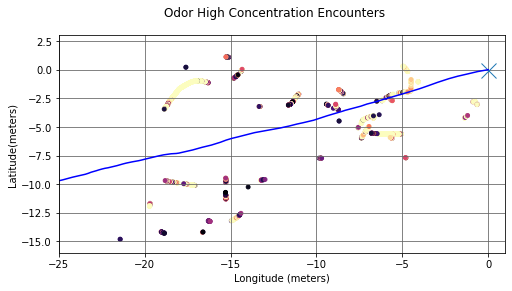

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor High Concentration Encounters')
ax = plt.axes (xlim=(-9,4), ylim=(-2,9))
# Plot the data
ax.scatter(df_t.xsrc, df_t.ysrc, c=df_t.odor, cmap='magma', s= 15)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, markersize=20, c='b')


#### ANIMATION 02 - Ideal vs Encountered Odor

In [ ]:
## Setting figure

fig = plt.figure()
ax = plt.axes(xlim=(-9,4), ylim=(-2,9))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()

wind, = ax.plot([],[], 'o', color ="b", lw = 2)
line, = ax.scatter([],[], c = geodfsub.odor, cmap='magma', s= 15)

def init():
    line.set_data([],[])  
    wind.set_data([],[])
    return wind,

def get_data_we_(i):
    return dfwe.loc[i]

def get_data_ns_(i):
    return dfns.loc[i]

def get_data_x_(i):
    return geodfsub.xsrc[i]

def get_data_y_(i):
    return geodfsub.ysrc[i]

def update(i):
#     wex = get_data_we_(i)
#     nsy = get_data_ns_(i)
#     wind.set_data(wex,nsy)
    x = get_data_x_(i)
    y = get_data_y_(i)
    line.set_data(x,y)
    
    return line,




In [19]:
# ani = animation.FuncAnimation(fig, update, init_func=init, frames = int(len(geodfsub.ysrc)/2), interval = 5, blit=False)
ani = animation.FuncAnimation(fig, update, init_func=init, frames = 500, interval = 5, blit=False)


#ani.save('../../../Research/Images/Video/test_ideal.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
#HTML(ani.to_html5_video())




#### Note: Number of rows for wind sensor for a certain time slot is much lesser than number of rows of the data collected (position data) >>>> GPS frequency is much higher